## Benchmarks against random sampling

In the following we benchmark the performacnce of the adaptable experimantalist against randome sampling on two different experimanets in an automated close loop setting.

In [1]:
# experimentalists
from autora.experimentalist.adaptable import adaptable_sample
from autora.experimentalist.confirmation import confirmation_score_sample
from autora.experimentalist.falsification import falsification_score_sample
from autora.experimentalist.model_disagreement import model_disagreement_score_sample
from autora.experimentalist.novelty import novelty_score_sample
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample

# theorists
# from autora.theorist.bms import BMSRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# experiment_runner
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio
from autora.experiment_runner.synthetic.psychology.exp_learning import exp_learning
from autora.experiment_runner.synthetic.psychology.q_learning import q_learning
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory
from autora.experiment_runner.synthetic.economics.prospect_theory import prospect_theory
from autora.experiment_runner.synthetic.neuroscience.task_switching import task_switching
from autora.experiment_runner.synthetic.psychophysics.stevens_power_law import stevens_power_law
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law

# autora state
from autora.state import State, StandardState, on_state, estimator_on_state, Delta, VariableCollection

# sklearn
from sklearn.base import BaseEstimator
from sklearn import linear_model

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, List
import os

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import logging

logging.basicConfig(level=logging.ERROR)

Utility classes and functions

In [2]:
# Set up costum state
# Here, we use a non-standard State to be able to use a multiple models
@dataclass(frozen=True)
class CustomState(State):
    variables: Optional[VariableCollection] = field(default=None, metadata={"delta": "replace"})
    conditions: Optional[pd.DataFrame] = field(default=None, metadata={"delta": "replace", "converter": pd.DataFrame})
    experiment_data: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "extend", "converter": pd.DataFrame}
    )
    models_lr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polyr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )

class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
        self.poly = PolynomialFeatures(degree=degree, include_bias=False)
        self.model = LinearRegression()

    def fit(self, x, y):
        features = self.poly.fit_transform(x, y)
        self.model.fit(features, y)
        return self

    def predict(self, x):
        features = self.poly.fit_transform(x)
        return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)


# the following function is used to compute the model performance
# on the validation set in terms of mean squared error
def get_validation_MSE(validation_experiment_data, working_state):
    ivs = [iv.name for iv in validation_experiment_data.variables.independent_variables]
    dvs = [dv.name for dv in validation_experiment_data.variables.dependent_variables]
    X = validation_experiment_data.experiment_data[ivs]
    y = validation_experiment_data.experiment_data[dvs]

    y_pred_lr = working_state.models_lr[-1].predict(X)
    y_pred_polyr = working_state.models_polyr[-1].predict(X)

    MSE_lr = ((y - y_pred_lr) ** 2).mean().iloc[0]
    MSE_polyr = ((y - y_pred_polyr) ** 2).mean().iloc[0]

    min_MSE = min(MSE_lr, MSE_polyr)

    return min_MSE

def plot_MSE(
    benchmark_MSE_log,
    working_MSE_log,
    title="Single Discovery Simulation",
    filename="plots/single_discovery_simulation.png",
    save_plot=False,
):
    fig, ax = plt.subplots(1, 1)
    ax.plot(benchmark_MSE_log, label="benchmark_MSE_log")
    ax.plot(working_MSE_log, label="working_MSE_log")
    ax.set_xlabel("Sampled Data Points")
    ax.set_ylabel("MSE on Validation Set")
    ax.set_title(title)
    ax.legend()
    plt.show()
    if save_plot:
        os.makedirs("plots", exist_ok=True)
        fig.savefig(filename)

def plot_mean_MSE_with_errorbar(
    benchmark_MSE_plot_data,
    working_MSE_plot_data,
    num_cycles,
    title="Averaged Discovery Simulations",
    filename="plots/averaged_discovery_simulations.png",
    save_plot=False,
):
    fig, ax = plt.subplots(1, 1)
    ax.errorbar(
        np.arange(num_cycles),
        np.mean(benchmark_MSE_plot_data, axis=0),
        yerr=np.std(benchmark_MSE_plot_data, axis=0),
        label="benchmark_MSE_log",
    )
    ax.errorbar(
        np.arange(num_cycles),
        np.mean(working_MSE_plot_data, axis=0),
        yerr=np.std(working_MSE_plot_data, axis=0),
        label="working_MSE_log",
    )
    ax.set_xlabel("Sampled Data Points")
    ax.set_ylabel("MSE on Validation Setc")
    ax.set_title(title)
    ax.legend()
    plt.show()
    if save_plot:
        os.makedirs("plots", exist_ok=True)
        fig.savefig(filename)

On state functions

In [3]:
# **** STATE WRAPPER FOR YOUR EXPERIMENTALIST ***
@on_state()
def custom_sample_on_state(
    experiment_data,
    variables,
    models_lr,
    models_polyr,
    all_conditions,
    cycle=None,
    max_cycle=None,
    num_samples=1,
    random_state=None,
):

    # very simple temperature regulation
    # temperature = 0.6 * (1 - (cycle / max_cycle))
    temperature = 0.1

    # get the input relevant to some of the samplers
    # independent and dependent variables for the metadata
    iv = variables.independent_variables
    dv = variables.dependent_variables
    meta_data = VariableCollection(independent_variables=iv, dependent_variables=dv)

    # reference conditions and observations
    ivs = [iv.name for iv in variables.independent_variables]
    dvs = [dv.name for dv in variables.dependent_variables]
    reference_conditions = experiment_data[ivs]
    reference_observations = experiment_data[dvs]

    # remove the conditions that have already been sampled from the conditions pool
    # remove reference conditions from the conditions pool
    if isinstance(all_conditions, pd.DataFrame) and isinstance(reference_conditions, pd.DataFrame):
        conditions_pool = pd.concat([all_conditions, reference_conditions])
        conditions_pool = conditions_pool.drop_duplicates(keep=False)
    else:
        conditions_pool = all_conditions[~all_conditions.isin(reference_conditions)].dropna()

    # NOTE: the sampler is performeing a bit worse when including falsification and confirmation
    #       possiblly due to passing only one model to theses samplers
    #       while the performance is based on 3 models
    samplers = [
        {
            "func": novelty_score_sample,
            "name": "novelty",
            "params": {"reference_conditions": reference_conditions},
        },
        {
            "func": falsification_score_sample,
            "name": "falsification",
            "params": {
                "reference_conditions": reference_conditions,
                "reference_observations": reference_observations,
                "metadata": meta_data,
                "model": models_polyr[-1],
            },
        },
        {
            "func": model_disagreement_score_sample,
            "name": "model_disagreement",
            "params": {
                "models": [models_lr[-1], models_polyr[-1]],
            },
        },
        {
            "func": confirmation_score_sample,
            "name": "confirmation",
            "params": {
                "reference_conditions": reference_conditions,
                "reference_observations": reference_observations,
                "metadata": meta_data,
                "model": models_polyr[-1],
            },
        },
    ]
    # samplers_coords = [0, 1, 3, 4, 6]  # optional
    # samplers_coords = [1, 2, 5]
    samplers_coords = [0, 2, 3, 4]

    adaptable_sampler_sensitivity = 12

    new_conditions = adaptable_sample(
        conditions=conditions_pool,
        reference_conditions=reference_conditions,
        models=models_polyr,  # pass only the polyr models
        samplers=samplers,
        num_samples=num_samples,
        samplers_coords=samplers_coords,
        sensitivity=adaptable_sampler_sensitivity,
        temperature=temperature,
        plot_info=False,
    )

    return Delta(conditions=new_conditions)

# state wrapper for all theorists
@on_state()
def theorists_on_state(experiment_data, variables):

    # extract conditions X and observations y from experiment data
    ivs = [iv.name for iv in variables.independent_variables]
    dvs = [dv.name for dv in variables.dependent_variables]
    X = experiment_data[ivs]
    y = experiment_data[dvs]

    # initialize and fit theorists
    theorist_polyr = PolynomialRegressor()
    theorist_lr = linear_model.LinearRegression()

    return Delta(
        models_lr=[theorist_lr.fit(X, y)], models_polyr=[theorist_polyr.fit(X, y)]
    )

# state wrapper for grid pooler experimentalist (generates a grid of experiment conditions)
@on_state()
def grid_pool_on_state(variables):
    return Delta(conditions=grid_pool(variables))

# state wrapper for random pooler experimentalist (generates a pool of experiment conditions)
@on_state()
def random_pool_on_state(variables, num_samples, random_state=None):
    return Delta(conditions=random_pool(variables, num_samples, random_state))

# state wrapper for random experimentalist (samples experiment conditions from a set of conditions)
@on_state()
def random_sample_on_state(conditions, all_conditions, num_samples, random_state=None):
    return Delta(conditions=random_sample(all_conditions, num_samples, random_state))

# state wrapper for synthetic experiment runner
@on_state()
def run_experiment_on_state(conditions, experiment_runner):
    data = experiment_runner.run(conditions=conditions, added_noise=0.0)
    return Delta(experiment_data=data)


Automated close loop function

In [4]:
def run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, experiment_runner, sim=0):
    # VALIDATION STATE
    # at every step of our discovery process, we will evaluate the performance
    # of the theorist against the ground truth. Here, we will define the ground
    # truth as a grid of data points sampled across the domain of the experimental
    # design space. We will store this validation set in a separate validation states

    # create AutoRA state for validation purposes
    # our validation set will be consist of a grid of experiment conditons
    # across the entire experimental design domain
    with ThreadPoolExecutor(max_workers=2) as executor:
        validation_conditions_future = executor.submit(
            grid_pool_on_state, CustomState(variables=experiment_runner.variables)
        )
        validation_experiment_data_future = executor.submit(
            grid_pool_on_state, CustomState(variables=experiment_runner.variables)
        )

    validation_conditions = validation_conditions_future.result()
    validation_experiment_data = run_experiment_on_state(
        validation_experiment_data_future.result(), experiment_runner=experiment_runner
    )

    benchmark_MSE_log = list()
    working_MSE_log = list()

    # INITIAL STATE
    # We begin our discovery experiment with randomly sampled data set for 10
    # conditions. We will use the same state for each experimentalist method.

    # create initial AutoRA state which we will use for our discovery expeirments
    initial_state = CustomState(variables=experiment_runner.variables)

    # we will initiate our discovery process with 10 randomly sampled experiment conditions
    initial_state = random_pool_on_state(initial_state, num_samples=num_initial_conditions, random_state=sim)

    # we obtain the corresponding experiment data
    initial_state = run_experiment_on_state(initial_state, experiment_runner=experiment_runner)

    # initialize benchmark state for random experimentalist
    benchmark_state = CustomState(**initial_state.__dict__)

    # initialize working state for your custom experimentalist
    working_state = CustomState(**initial_state.__dict__)

    # for each discovery cycle
    for cycle in tqdm(range(num_cycles), leave=True, desc="discovery cycles"):

        logging.info("SIMULATION " + str(sim) + " / DISCOVERY CYCLE " + str(cycle))

        # first, we fit a model to the data
        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_future = executor.submit(theorists_on_state, benchmark_state)
            working_future = executor.submit(theorists_on_state, working_state)

        benchmark_state = benchmark_future.result()
        working_state = working_future.result()

        # now we can determine how well the models do on the validation set
        # MSE calculation in parallel
        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_MSE_future = executor.submit(get_validation_MSE, validation_experiment_data, benchmark_state)
            working_MSE_future = executor.submit(get_validation_MSE, validation_experiment_data, working_state)

        benchmark_MSE_log.append(benchmark_MSE_future.result())
        working_MSE_log.append(working_MSE_future.result())

        # then we determine the next experiment condition
        # we obtain the corresponding experiment data
        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_sample_future = executor.submit(
                random_sample_on_state,
                benchmark_state,
                all_conditions=validation_conditions.conditions,
                num_samples=num_conditions_per_cycle,
            )
            working_sample_future = executor.submit(
                custom_sample_on_state,
                working_state,
                all_conditions=validation_conditions.conditions,
                num_samples=num_conditions_per_cycle,
                cycle=cycle,
                max_cycle=num_cycles,
            )

        benchmark_state = benchmark_sample_future.result()
        working_state = working_sample_future.result()

        # we run the experiment and update the experiment data
        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_experiment_future = executor.submit(
                run_experiment_on_state, benchmark_state, experiment_runner=experiment_runner
            )
            working_experiment_future = executor.submit(
                run_experiment_on_state, working_state, experiment_runner=experiment_runner
            )

        benchmark_state = benchmark_experiment_future.result()
        working_state = working_experiment_future.result()

    return benchmark_MSE_log, working_MSE_log, benchmark_state, working_state

Next we put everything together and we run multiple cycles with both the adaptable experimentalist and random sampling on two experiments.
Finally we compare the performance of the two methods.

In [5]:
# meta parameters
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1

# YOU MAY CHANGE THESE PARAMETERS
num_discovery_simulations = 10

experiment_runners = [
    # psychology
    luce_choice_ratio(),
    exp_learning(),
    # economics
    # expected_value_theory(),
    prospect_theory(),
    # neuroscience
    # task_switching(),
    # psychophysics
    # weber_fechner_law(),
]

In [ ]:
# Single Discovery Simulations
single_MSE_log = dict()
for experiment_runner in tqdm(
    experiment_runners, total=len(experiment_runners), leave=True, desc="experiment runners single"
):
    logging.info("## Running simulation for " + experiment_runner.name)

    benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(
        num_cycles, num_conditions_per_cycle, num_initial_conditions, experiment_runner
    )
    single_MSE_log[experiment_runner.name] = {
        "benchmark_MSE_log": benchmark_MSE_log,
        "working_MSE_log": working_MSE_log,
    }

    logging.info("## Finished simulation for " + experiment_runner.name)
    logging.info("## -----------------------------------------")


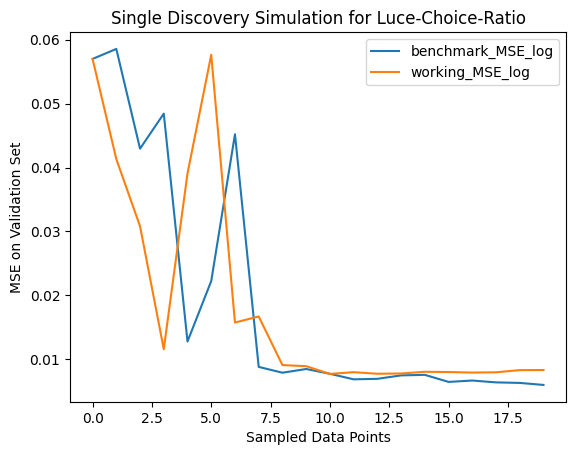

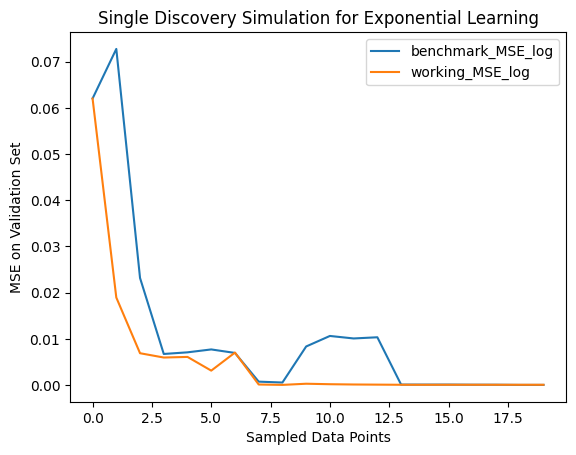

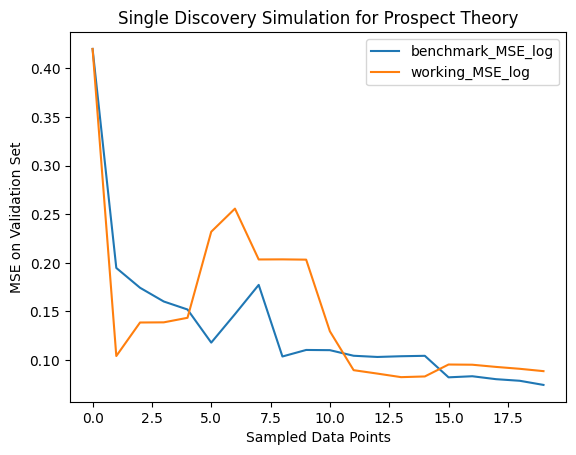

In [7]:
# plot the results
SAVE_PLOTS = False
for key, value in single_MSE_log.items():
    plot_MSE(
        value["benchmark_MSE_log"],
        value["working_MSE_log"],
        title="Single Discovery Simulation for " + key,
        filename="plots/single_sim_" + key + ".png",
        save_plot=SAVE_PLOTS,
    )

In [ ]:

# Averaged Discovery Simulations over multiple runs
average_MSE_log = dict()
for experiment_runner in tqdm(
    experiment_runners, total=len(experiment_runners), leave=True, desc="experiment runners average"
):
    logging.info("## Running simulation for " + experiment_runner.name)

    benchmark_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])
    working_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])

    for sim in tqdm(
        range(num_discovery_simulations), total=num_discovery_simulations, leave=True, desc="discovery simulations"
    ):
        benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(
            num_cycles, num_conditions_per_cycle, num_initial_conditions, experiment_runner, sim
        )

        benchmark_MSE_plot_data[sim, :] = benchmark_MSE_log
        working_MSE_plot_data[sim, :] = working_MSE_log

    average_MSE_log[experiment_runner.name] = {
        "benchmark_MSE_log": benchmark_MSE_plot_data,
        "working_MSE_log": working_MSE_plot_data,
    }

    logging.info("## Finished simulation for " + experiment_runner.name)
    logging.info("## -----------------------------------------")

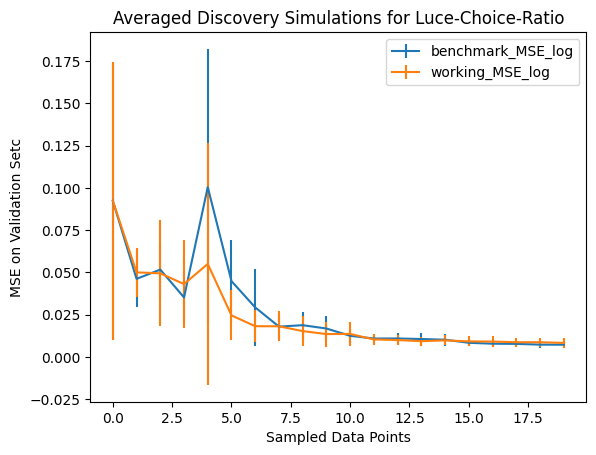

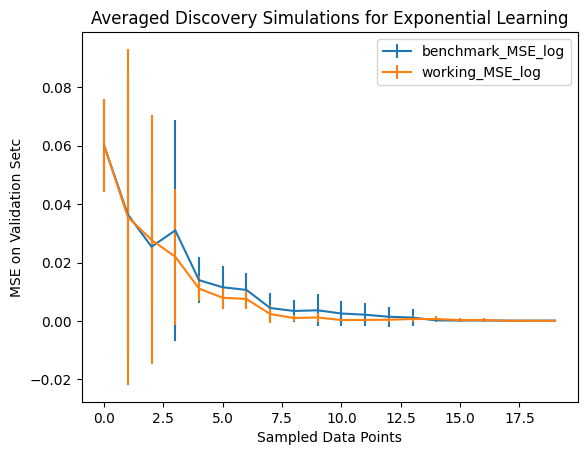

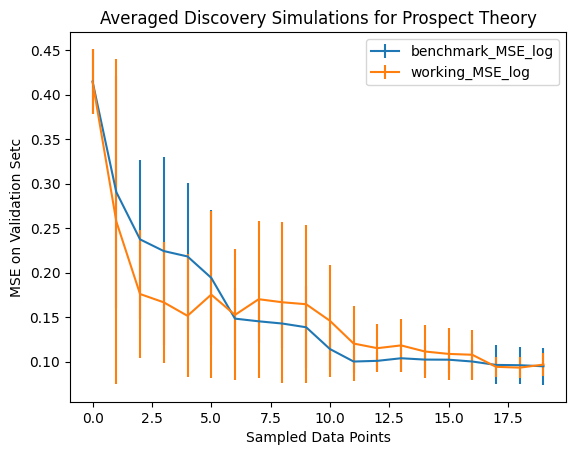

In [9]:
# plot the results
SAVE_PLOTS = False
for key, value in average_MSE_log.items():
    plot_mean_MSE_with_errorbar(
        value["benchmark_MSE_log"],
        value["working_MSE_log"],
        num_cycles,
        title="Averaged Discovery Simulations for " + key,
        filename="plots/avg_sims_" + key + ".png",
        save_plot=SAVE_PLOTS,
    )